In [19]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics
from xgboost import XGBClassifier

## Proprocessing

In [5]:
data = pd.read_csv('data/basecompleta.csv',sep=';', decimal=",")
#data[["Y_PROP","Y_PROP2"]]
data=data.sort_values('ANO')
data= data.drop(['Y_PROP2'],axis=1)
data.head()

,ANO,ID_ESPACIA,DEPTO,MUNICIPIO,Y_PROP,CUL_ILI,GRUPO_ARMA,ACCION_ARMADA,MINAS,INFRACCIONES_H,ACTO_TERRO
0,2002,27099,CHOCO,BOJAYA,0.880000,0,1,1,0,272,104
6352,2002,52254,NARIÑO,EL PEÑOL,0.006950,0,1,1,0,21,0
9558,2002,41001,HUILA,NEIVA,0.002760,0,1,1,4,226,13
2938,2002,50226,META,CUMARAL,0.020946,0,1,1,0,100,0
2939,2002,68147,SANTANDER,CAPITANEJO,0.020945,0,1,1,0,20,2


In [8]:
# normalizing Infacciones_H; Minas and ACTO_TERRO
# Every variable must have the same unit so that each one has has the same effect.

norm = Normalizer(copy=True, norm='l2')
years=data['ANO'].unique() 

data_list = []
for year in years:
    a=data[data['ANO']==year]
    X = a[['MINAS','INFRACCIONES_H','ACTO_TERRO']].values
    normalized_values = norm.fit_transform(X)
    a.loc[:,['MINAS','INFRACCIONES_H','ACTO_TERRO']]=normalized_values
    a = a.reset_index(drop=True)
    data_list.append(a)

data2 = pd.concat(data_list,ignore_index=True)
data2.head()

/root/.virtualenvs/ds4a-py3/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/root/.virtualenvs/ds4a-py3/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/root/.virtualenvs/ds4a-py3/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,ANO,ID_ESPACIA,DEPTO,MUNICIPIO,Y_PROP,CUL_ILI,GRUPO_ARMA,ACCION_ARMADA,MINAS,INFRACCIONES_H,ACTO_TERRO
0,2002,27099,CHOCO,BOJAYA,0.880000,0,1,1,0.000000,0.934052,0.357137
1,2002,52254,NARIÑO,EL PEÑOL,0.006950,0,1,1,0.000000,1.000000,0.000000
2,2002,41001,HUILA,NEIVA,0.002760,0,1,1,0.017667,0.998194,0.057418
3,2002,50226,META,CUMARAL,0.020946,0,1,1,0.000000,1.000000,0.000000
4,2002,68147,SANTANDER,CAPITANEJO,0.020945,0,1,1,0.000000,0.995037,0.099504


## Clustering Model

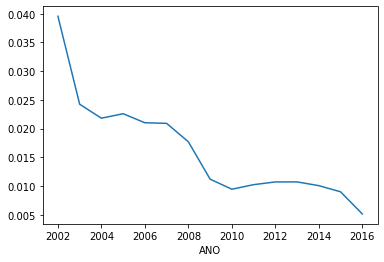

<Figure size 432x288 with 0 Axes>

In [9]:
# getting victims proportion per year
data.groupby(['ANO'])['Y_PROP'].mean().plot()
plt.show()
plt.clf()

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ANO,14840.0,2008.812197,4.307442,2002.0,2005.000000,2009.000000,2013.000000,2016.00
ID_ESPACIA,14840.0,39554.014825,26648.538034,5001.0,15778.000000,27430.000000,68001.000000,99773.00
Y_PROP,14840.0,0.016651,0.039579,0.0,0.001654,0.005161,0.016002,0.88
CUL_ILI,14840.0,0.168059,0.373932,0.0,0.000000,0.000000,0.000000,1.00
GRUPO_ARMA,14840.0,0.728437,0.444781,0.0,0.000000,1.000000,1.000000,1.00
ACCION_ARMADA,14840.0,0.780660,0.413813,0.0,1.000000,1.000000,1.000000,1.00
MINAS,14840.0,0.697574,3.249085,0.0,0.000000,0.000000,0.000000,73.00
INFRACCIONES_H,14840.0,30.583491,106.222477,0.0,0.000000,5.000000,25.000000,6766.00
ACTO_TERRO,14840.0,4.073383,30.830330,0.0,0.000000,0.000000,1.000000,1337.00


In [12]:
list(data2)
data2002 = data2[data2['ANO']==2002].reset_index(drop=True)
X= data2002.drop(['ID_ESPACIA','DEPTO','MUNICIPIO','ANO'],axis=1)

In [13]:
X

,Y_PROP,CUL_ILI,GRUPO_ARMA,ACCION_ARMADA,MINAS,INFRACCIONES_H,ACTO_TERRO
0,0.880000,0,1,1,0.000000,0.934052,0.357137
1,0.006950,0,1,1,0.000000,1.000000,0.000000
2,0.002760,0,1,1,0.017667,0.998194,0.057418
3,0.020946,0,1,1,0.000000,1.000000,0.000000
4,0.020945,0,1,1,0.000000,0.995037,0.099504
...,...,...,...,...,...,...,...
1033,0.069265,1,1,1,0.000000,0.999600,0.028272
1034,0.007761,0,1,1,0.000000,0.998274,0.058722
1035,0.004675,0,1,1,0.000000,1.000000,0.000000
1036,0.004630,0,1,1,0.000000,1.000000,0.000000


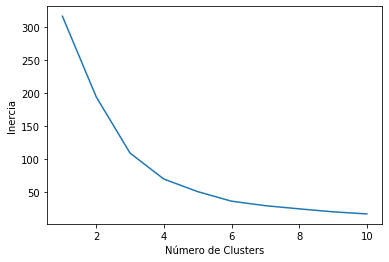

In [14]:
inertias = np.array([])
num_clusters = np.linspace(1,10,dtype='int',num=10)

for num_cluster in num_clusters:
    kmeans=KMeans(n_clusters=num_cluster,random_state=123).fit(X)
    inertias = np.append(inertias,kmeans.inertia_)


plt.plot(num_clusters,inertias)
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia")
plt.show()

In [15]:
kmeans=KMeans(n_clusters=3,random_state=123).fit(X)

In [16]:
data2002['GRUPO']=kmeans.labels_

In [17]:
data2002.groupby('GRUPO').mean().T
data2002.groupby('GRUPO')['ID_ESPACIA'].nunique()

data2002[[]]

""
0
1
2
3
4
...
1033
1034
1035
1036


In [20]:
X = data2002.drop(['ID_ESPACIA','DEPTO','MUNICIPIO','GRUPO'],axis=1)
clusters = np.linspace(0,2,3,dtype='int')

len(list(X))
importances = np.zeros(shape=(3,8))

for i in range(3):
    Y = np.where(data2002['GRUPO']==i,"1","0")
    xgb = XGBClassifier(max_depth=6,n_estimators=100,importance_type='gain',random_state=123)
    xgb.fit(X,Y)
    importances[i,:]=xgb.feature_importances_


In [21]:
importances

array([[0.00000000e+00, 1.19308906e-03, 9.98271108e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.35786501e-04, 0.00000000e+00],
       [0.00000000e+00, 7.76760280e-04, 7.71369219e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.27570981e-01, 2.83007743e-04],
       [0.00000000e+00, 4.44476929e-04, 8.37032422e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 9.15852308e-01, 0.00000000e+00]])

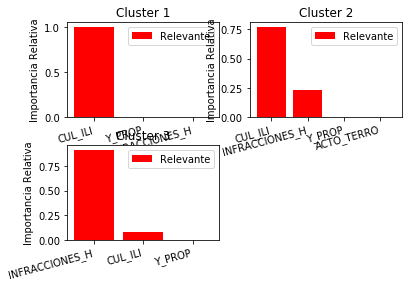

<Figure size 432x288 with 0 Axes>

In [22]:
list(X)
variables = X.columns

for i in range(3):
    imp_cluster = pd.DataFrame({'VARIABLE':variables,'IMPORTANCIA':importances[i,:]})
    imp_cluster = imp_cluster.sort_values(by='IMPORTANCIA',ascending=False).reset_index(drop=True)
    imp_cluster['CUMSUM']=imp_cluster['IMPORTANCIA'].cumsum()
    imp_cluster['SIGNIF']=np.where(imp_cluster['CUMSUM']<=0.,"Relevante","No Relevante")
    imp_cluster = imp_cluster[imp_cluster.IMPORTANCIA!=0]
    imp_cluster
    plt.subplot(2,2,i+1)    
    color = np.where(imp_cluster['SIGNIF']=='Relevante','b','r')
    plt.bar(x=imp_cluster.index,height=imp_cluster.IMPORTANCIA,color=color)
    plt.legend(('Relevante','No Relevante'))
    plt.xticks(np.arange(0,len(imp_cluster)),labels=np.array(imp_cluster['VARIABLE']),multialignment='center',rotation=15,ha='right',fontsize=10)
    plt.ylabel('Importancia Relativa')
    plt.title("Cluster {}".format(i+1))
    

plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()
plt.clf()

In [23]:
data_list = []
years=data2['ANO'].unique() #contiene los valores unicos de los años

for year in years:
    a=data2[data2['ANO']==year]
    X = a.drop(['ID_ESPACIA','DEPTO','MUNICIPIO','ANO'],axis=1)
    clust = kmeans.predict(X)
    a['GRUPO']=clust
    a = a.reset_index(drop=True)
    data_list.append(a) ## pegarle por debajo un objeto a una lista (.appended)

data3 = pd.concat(data_list,ignore_index=True)

data3.head()


data3.groupby(['ANO','GRUPO'])['ID_ESPACIA'].count()

data2002['GRUPO'].value_counts()

data3[(data3['GRUPO']==0) & (data3['ANO']==2003)& (data3['ID_ESPACIA']==15047)]

/root/.virtualenvs/ds4a-py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/root/.virtualenvs/ds4a-py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/root/.virtualenvs/ds4a-py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,ANO,ID_ESPACIA,DEPTO,MUNICIPIO,Y_PROP,CUL_ILI,GRUPO_ARMA,ACCION_ARMADA,MINAS,INFRACCIONES_H,ACTO_TERRO,GRUPO
